# vgg16 architecture with sgd momentum optimizer and L2 regularization, **data standardized**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
from torchinfo import summary
from pytorch_data_augmentation import load_data, normalize_data
from typing import cast, List, Union

# Set random seed for reproducibility
torch.manual_seed(42)
cudnn.benchmark = True
# cudnn.deterministic = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters

In [3]:
BATCH_SIZE = 128
IMAGE_SIZE = 128

# Load Data

In [4]:
train_ds, val_ds = load_data(IMAGE_SIZE)

100%|██████████| 791918971/791918971 [00:40<00:00, 19590404.60it/s]


Extracting ../p008-lenet-cnn-model/pytorch/data/oxford-iiit-pet/images.tar.gz to ../p008-lenet-cnn-model/pytorch/data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 8390968.65it/s] 


Extracting ../p008-lenet-cnn-model/pytorch/data/oxford-iiit-pet/annotations.tar.gz to ../p008-lenet-cnn-model/pytorch/data/oxford-iiit-pet


In [5]:
class_names = train_ds.datasets[0].classes
NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")

Number of classes: 37
Number of training samples: 6248
Number of validation samples: 1101


# Calculating standardization parameters

In [6]:
# # Calculate the mean and std per channel
# mean = torch.zeros(3)
# std = torch.zeros(3)

# for i in range(len(train_ds)):
#     img, _ = train_ds[i]
#     # img = F.to_tensor(img)
#     mean += torch.mean(img, dim=(1, 2))
#     std += torch.std(img, dim=(1, 2))

# mean /= len(train_ds)
# std /= len(train_ds)

# print("Mean per channel:", mean)
# print("Std per channel:", std)

# # Mean per channel: tensor([0.4811, 0.4490, 0.3965]) wrong!!!
# # Std per channel: tensor([0.2225, 0.2198, 0.2219]) wromg!!!
# # Caution: defining above values to new_mean tensor result in new_mean is equal to mean
# # Reason: precision of float is 4 decimals by default in print options
# # Solution: mean.numpy() displays float32 and mean[0].item() displays float64

# print("Real Mean per channel:", mean.numpy())
# print("Real Std per channel:", std.numpy())
# # Real Mean per channel: [0.4810741  0.44897535 0.3964732 ]
# # Real Std per channel: [0.22246653 0.21981163 0.2218984 ]

In [7]:
mean = torch.tensor([0.4810741, 0.44897535, 0.3964732])
std = torch.tensor([0.22246653, 0.21981163, 0.2218984])

# Standardize dataset

In [8]:
# class TransformDataset(Dataset):
#     def __init__(self, dataset, transform=None):
#         self.dataset = dataset
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         img, label = self.dataset[idx]
#         if self.transform:
#             img = self.transform(img)
#         return img, label

# additional_transform = v2.Normalize(mean, std)
# train_ds = TransformDataset(train_ds, transform=additional_transform)
# val_ds = TransformDataset(val_ds, transform=additional_transform)

train_ds, val_ds = normalize_data(train_ds, val_ds, mean, std)


# DataLoader

In [9]:
dataset_sizes = {'train': len(train_ds), 'val': len(val_ds)}
# Create data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, prefetch_factor=2)
dataloaders = {'train': train_loader, 'val': val_loader}

# visualization

In [10]:
batch, classes = next(iter(dataloaders['train']))

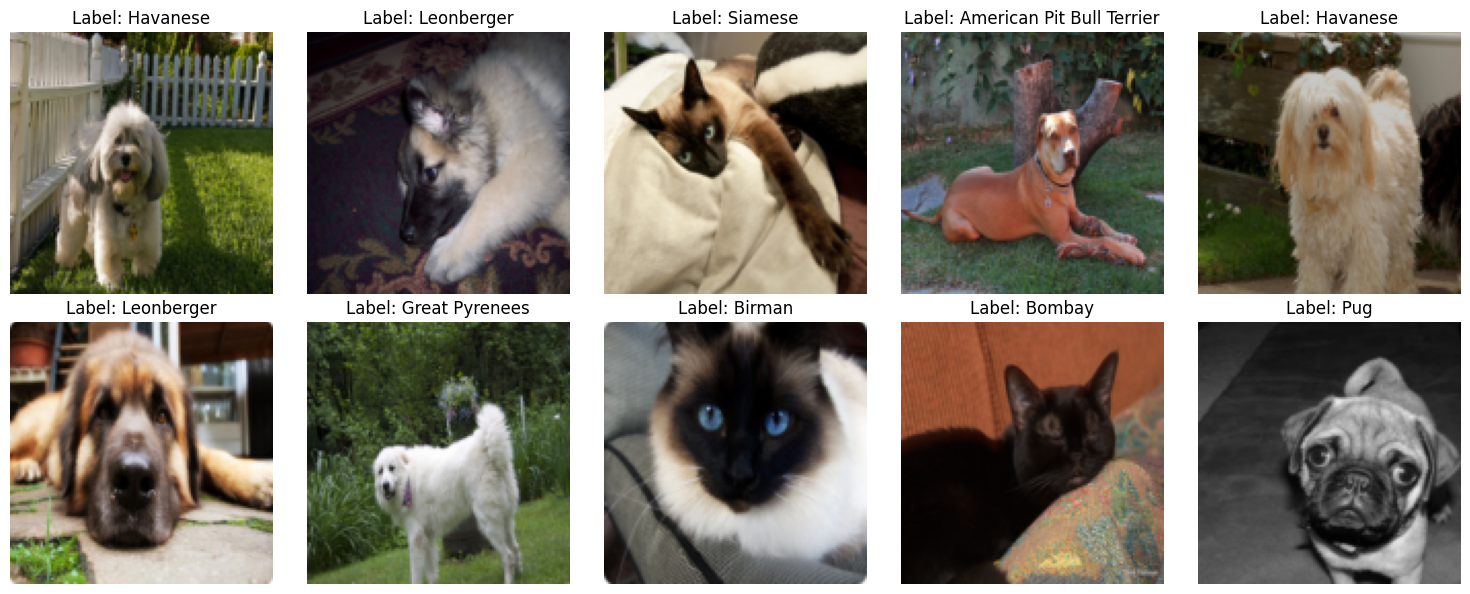

In [11]:
# Visualize 10 images from batch

r=2;c=5
fig, axs = plt.subplots(r, c, figsize=(3*c, 3*r))
for i in range(r*c):
    image = batch[i]
    label = classes[i]
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    axs[i // c, i % c].imshow(image)
    axs[i // c, i % c].set_title(f"Label: {class_names[torch.argmax(label).item()]}")
    axs[i // c, i % c].axis('off')

plt.tight_layout()
plt.show()

# Functions

## Training the model

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a directory to save training checkpoints
    best_model_params_path = './1_torch_vgg16_scratch.pth'

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.argmax(labels,1))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualizing the model predictions
Generic function to display predictions for a few images


In [13]:
def visualize_model(model, num_images=6, batch_num=0):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for batch_counter, (inputs, labels) in enumerate(dataloaders['val']):
            if batch_counter == batch_num:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                labelsss = torch.argmax(labels, 1)

                fig, axs = plt.subplots(num_images//5, 5, figsize=(3*5, int(3*(num_images//5))))
                for ax in axs.flat:
                    ax.axis('off')

                for img_count in range(inputs.size()[0]):
                    # imshow(inputs.cpu().data[img_count])
                    inp = inputs.cpu().data[img_count]
                    inp = inp.numpy().transpose((1, 2, 0))
                    inp = std * inp + mean
                    inp = np.clip(inp, 0, 1)
                    axs[img_count//5, img_count%5].imshow(inp)
                    axs[img_count//5, img_count%5].set_title(f'predicted: {class_names[preds[img_count]]} \n true: {class_names[labelsss[img_count]]}')

                    if img_count == num_images-1:
                        model.train(mode=was_training)
                        plt.tight_layout()
                        plt.show()
                        return

# VGG16 Model

In [14]:
def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [15]:
class VGG16(nn.Module):
    def __init__(self, cfg, NUM_CLASSES: int = 37, init_weights: bool = True, batch_norm: bool = False, dropout: float = 0.5):
        super().__init__()
        self.features = make_layers(cfg, batch_norm)
        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512*4*4, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, NUM_CLASSES),
        )
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    # weight is gamma, bias is beta; y=gamma*x+beta transformation thats why named weight and bias of batchnorm layer
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.classifier(x)
        return x



In [16]:
cfg = [64,64,'M', 128,128,'M', 256,256,256,'M', 512,512,512,'M', 512,512,512,'M']
VGG16_model = VGG16(cfg, NUM_CLASSES)
VGG16_model = VGG16_model.to(device)
summary(VGG16_model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), row_settings=["var_names"])

Layer (type (var_name))                  Output Shape              Param #
VGG16 (VGG16)                            [128, 37]                 --
├─Sequential (features)                  [128, 512, 4, 4]          --
│    └─Conv2d (0)                        [128, 64, 128, 128]       1,792
│    └─ReLU (1)                          [128, 64, 128, 128]       --
│    └─Conv2d (2)                        [128, 64, 128, 128]       36,928
│    └─ReLU (3)                          [128, 64, 128, 128]       --
│    └─MaxPool2d (4)                     [128, 64, 64, 64]         --
│    └─Conv2d (5)                        [128, 128, 64, 64]        73,856
│    └─ReLU (6)                          [128, 128, 64, 64]        --
│    └─Conv2d (7)                        [128, 128, 64, 64]        147,584
│    └─ReLU (8)                          [128, 128, 64, 64]        --
│    └─MaxPool2d (9)                     [128, 128, 32, 32]        --
│    └─Conv2d (10)                       [128, 256, 32, 32]        29

# Train and evaluate

In [17]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(VGG16_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

In [18]:
VGG16_model = train_model(VGG16_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 3.6121 Acc: 0.0267
val Loss: 3.6111 Acc: 0.0336

Epoch 1/19
----------
train Loss: 3.6102 Acc: 0.0296
val Loss: 3.6098 Acc: 0.0445

Epoch 2/19
----------
train Loss: 3.6062 Acc: 0.0351
val Loss: 3.6088 Acc: 0.0409

Epoch 3/19
----------
train Loss: 3.6043 Acc: 0.0269
val Loss: 3.6051 Acc: 0.0327

Epoch 4/19
----------
train Loss: 3.6004 Acc: 0.0389
val Loss: 3.5974 Acc: 0.0391

Epoch 5/19
----------
train Loss: 3.5892 Acc: 0.0386
val Loss: 3.5767 Acc: 0.0509

Epoch 6/19
----------
train Loss: 3.5664 Acc: 0.0461
val Loss: 3.5211 Acc: 0.0763

Epoch 7/19
----------
train Loss: 3.5228 Acc: 0.0549
val Loss: 3.4401 Acc: 0.0872

Epoch 8/19
----------
train Loss: 3.4708 Acc: 0.0658
val Loss: 3.3994 Acc: 0.0836

Epoch 9/19
----------
train Loss: 3.4304 Acc: 0.0707
val Loss: 3.3917 Acc: 0.0908

Epoch 10/19
----------
train Loss: 3.3992 Acc: 0.0736
val Loss: 3.3624 Acc: 0.0908

Epoch 11/19
----------
train Loss: 3.3788 Acc: 0.0826
val Loss: 3.3471 Acc: 0.1063

Ep

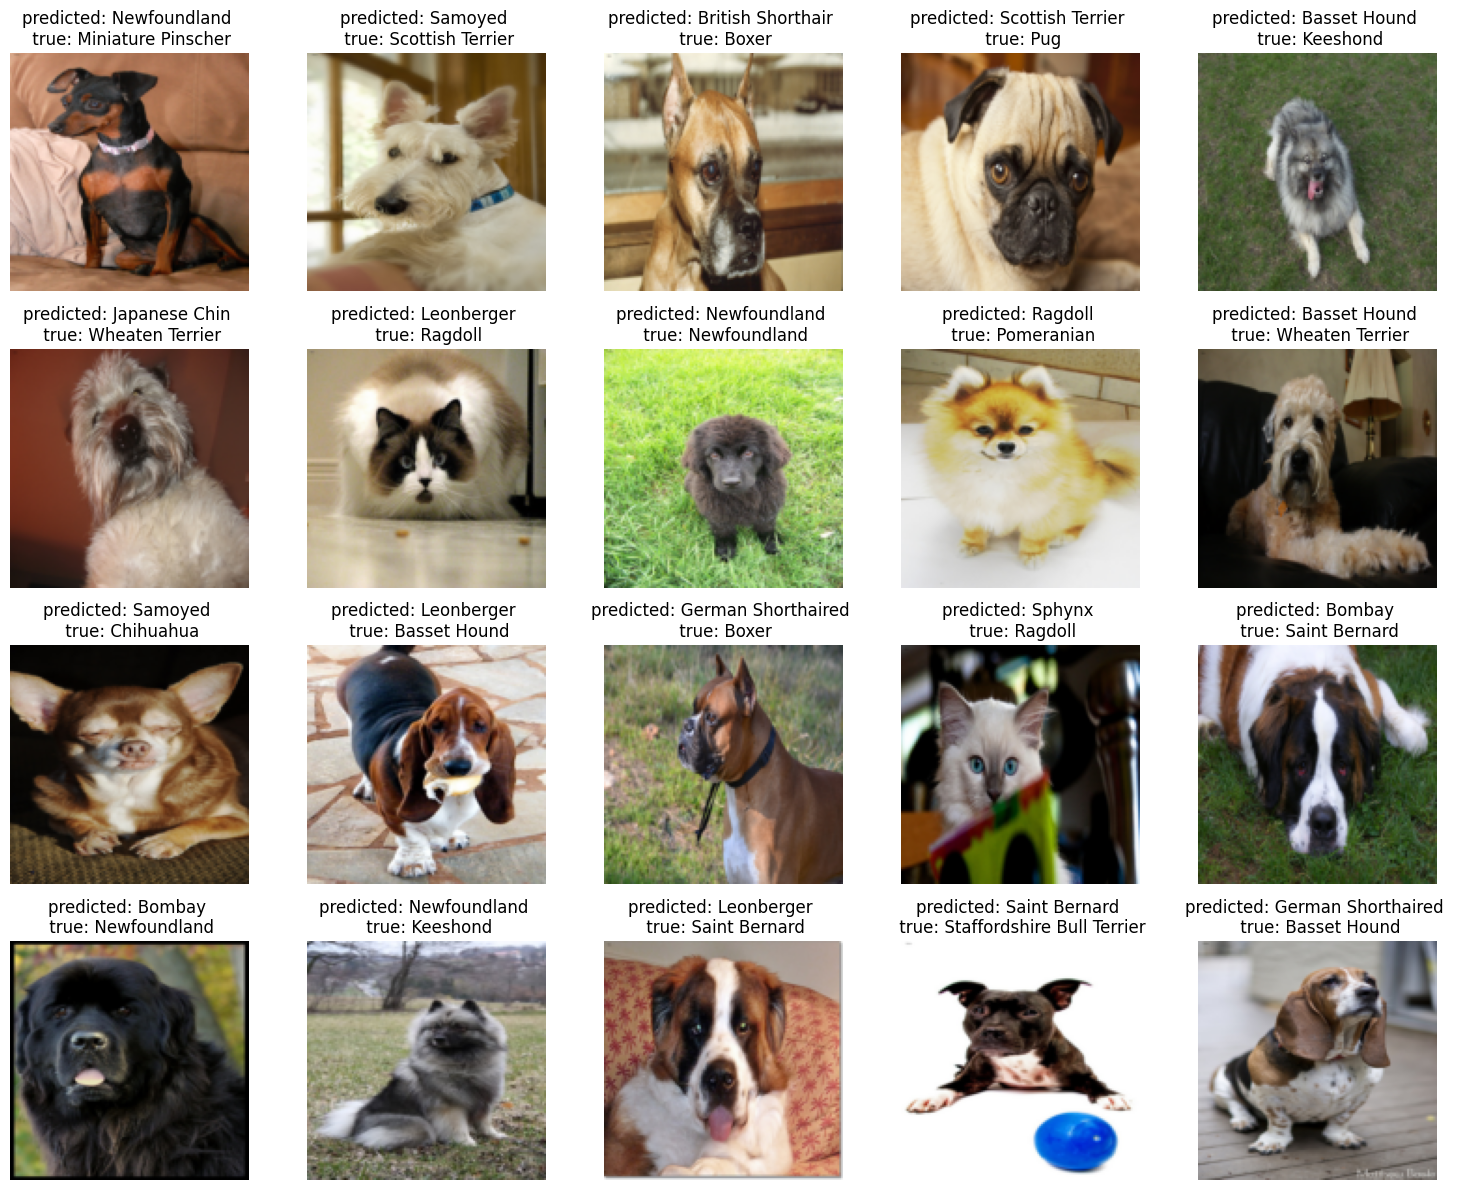

In [ ]:
visualize_model(VGG16_model, num_images=20, batch_num=1)